# Defactoring Pace of Change


TODO: introductory remarks about the defactoring process

One of the byproducts of defactoring is a deconstruction of the structure of the code. (heh) Yet, the implementation of what we doing is completely different, at least conceptually, from deconstruction

There is something processually different betwen deconstructing a text and deconstructing code. Where you would take a text and try to identify its meaningful sub-parts and their relations, with code, we are mirroring that process and putting the carefully deconstructed parts back together into one large linear narrative.

Good code is already deconstructed (refactored) into modules and composable parts, we are in effect turning good code into sub-optimal code.


NOtes on defactoring and writing computational narratives in the Notebook:

- What do you do with helper functions? How should helper functions be interwoven into a linear computational narrative?
- the global namespace is polluted as fuck
- We actually infer 1 possible execution path in this notebook (analyzing *all* exectution paths would be humanly infeasible: what do we do with code that isn't part of that path, do we represent it or not?
- What do we do with code that isn't executed as a result of the settings by Ted? We are including some of the non executed code (because ??) but not all of the non executed code. We don't have a very good rationale for this at the moment.
- Observation: It would require a book-sized examination to do full justice to code and execution pathways of this article. There are multiple potential pathways, rivers and tributaries of data and computation. To fully realize DEFACTORING as a critical method is to explicate all possibilities...but to do this is infeasble (at least without computational assistance). What would it mean to computationally explore these alternatives? 



We have altered Ted Underwood's code, the letter is changed, but the spirit of the work is the same. 



## Looking at the data


Before we dive into the code, we had a question about "what do they mean by *volume*?" in the Pace of Change article.

The answer, to be confirmed, lives in the [Understanding Genre in a Collection of a Million Volumes](https://figshare.com/articles/Understanding_Genre_in_a_Collection_of_a_Million_Volumes_Interim_Report/1281251). Basically, the idea of "volume" comes from the Hathi Trust.



Volume is equivalent to book. Volume is the Hathi Trust unit. 

> We worked with HathiTrust, which contains the aggregated collections of large public and university libraries; in the period we’re considering (1820-1919), that gave us a collection of roughly 758,400 books in English, of which about 53,200 include significant amounts of poetry. This doesn’t exhaustively cover print culture; it’s still a sample, with particular selection biases. (page 5)

It would seem the 53,200 number comes from the fact that Ted has page level genre information. The details of this can be found in an additional figshare repository, [Page-leve genre metadata](https://figshare.com/articles/Page_Level_Genre_Metadata_for_English_Language_Volumes_in_HathiTrust_1700_1922/1279201) where:

> Volumes of pentry often include proce introduction, or front and back matter; this was trimmed using publicly-available metadata. (page 33)

This is how he was able to extract individual poems from the Hathi Trust data.

TODO: We are going to need to be a bit more formal about how we represent the processes that created the data used in this code.

Joris and Matt had short discussion the potential for confounds in the *random* sample which might have skewed that sample because it had the potential to include reviewed poetry. Pages 33 and 34 for the Pace of Change talk about the sampling and data preparation. We needed to talk through exactly what they did to understand it fully. After our discussion we agreed with their reasoning, but we would have liked to see a few more numbers. For example, 

> when a stray volume from the random set turns up near the top of our model’s list of books likely to be reviewed, it does turn out that many of those authors are reasonably well-known (Rupert Brooke, Elaine Goodale Eastman). (page 33)

We would like to see more supporting data about the ratio between well-known and not-well-known authors popping up at the top of the model's list of books. Perhaps this is splitting hairs, but it would be good to have this supporting data. This however raises the question about how to formalize the "well-knownness" of a particular author. This utlimately might be more of a commentary upon our total ignorance of 19th century poetry, Matt and Joris are not English literary scholars (Joris is a Dutch literary scholar) and as such neither of us know very much about 19th century poets. Basically, we don't know much about Rupert Brooke and Elaine Goodale Eastman. This is perhaps a minor nitpick.

Our question is "How many *well-known* authors were in the random sample?"

## Looking at the shape of the data

The poems live in the `poems` directory. Here is what they look like:

In [1]:
!head -n20 poems/dul1.ark+\=13960\=t5fb5xg2z.poe.tsv

,	2745
the	1445
and	1182
.	672
of	468
to	442
:	386
in	384
;	324
a	253
but	228
his	223
he	218
|'s|	211
with	198
—	197
that	188
on	187
they	172
for	171


poems are represented as word frequency counts. 


We should also be mindful of what information is captured by the metadata:

In [2]:
!head -n20 poemeta.csv

docid,actualdate,inferreddate,firstpub,recept,recordid,OCLC,author,imprint,enumcron,title,pubrev,judge,impaud,yrrev,pubname,birth,gender,nationality,othername,notes,canon
loc.ark+=13960=t8sb4zz1q,1921,1921,1921,addcanon,537314,,"Lawrence, D. H.",New York;T. Seltzer;1921.,,Tortoises,,,,,,1885,m,uk,,,y
uc1.b3342759,1919,1919,1919,random,7930862,,"Wigren, Bessie C.",Boston;The Poet Lore Company;c1919,,Summer wind,,,,,,1874,f,us,,,
uc1.b4100590,1918,1918,1918,reviewed,6154122,2143179,"Waugh, Alec,",London;G. Richards;1918.,,Resentment,rev,,,1918,EGO,1898,m,uk,,,
uc1.b3340220,1918,1918,1918,reviewed,7917249,12688503,"Nightingale, M.",Oxford [Oxfordshire;B.H. Blackwell;1918.,,Verses wise and otherwise,rev,neg,,1919,EGO,1879,f,uk,,,
uc2.ark+=13960=t0ft8gj1k,1918,1918,1918,reviewed,7657411,2518108,"Faber, Geoffrey,","Oxford;B. H. Blackwell;New York;Longmans, Green & Co.;1918.",,In the valley of vision,rev,,,1918,EGO,1889,m,uk,,,
uc2.ark+=13960=t6k070h7g,1918,1918,1918,reviewed,6607061,2809404,

## Diving into `replicate.py`

So this is not exact copy of replicate.py, instead we have *defactored* the code by starting at the branch point at line 45 of replicate.py (git commit e2b5b8f9a86d3f80360865a6628488619f7849d6). Basically everything after `if command == 'full':` and before `elif command == 'quarters':` 

MJ: The 'rest' of this module basically splits of 6 branches of the process related to the six possible ways of carving up the data `{"full", "quarters", "nations", "genders", "canon", "halves"}`, each option sets the different paramaters for the analytic process associated with that specific command. 

For reasons of feasibility we will only examine the first branching off tied to the command 'full'.
'Full' means: 
> process all 700 volumes model represented in Fig. 1 of the article 

(cf. "model the full 700-volume dataset using default settings" above)


In [3]:
## PATHS.

sourcefolder = 'poems/'
extension = '.poe.tsv'
classpath = 'poemeta.csv'
outputpath = 'mainmodelpredictions.csv'

## EXCLUSIONS.

excludeif = dict()
excludeif['pubname'] = 'TEM'
# We're not using reviews from Tait's.

excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.

excludeifnot = dict()
excludeabove = dict()
excludebelow = dict()

excludebelow['firstpub'] = 1700
excludeabove['firstpub'] = 1950
sizecap = 360

# For more historically-interesting kinds of questions, we can limit the part
# of the dataset that gets TRAINED on, while permitting the whole dataset to
# be PREDICTED. (Note that we always exclude authors from their own training
# set; this is in addition to that.) The variables futurethreshold and
# pastthreshold set the chronological limits of the training set, inclusive
# of the threshold itself.

## THRESHOLDS

futurethreshold = 1925
pastthreshold = 1800

# CLASSIFY CONDITIONS

positive_class = 'rev'
category2sorton = 'reviewed'
datetype = 'firstpub'
numfeatures = 3200
regularization = .00007

The code cell above is the specification of a bunch of parameters. It is a pretty inn

In [4]:
# rawaccuracy, allvolumes, coefficientuples = pc.create_model(paths, exclusions, thresholds, classifyconditions)


This is the point in replicate.py where the script calls out to a function in a separate file, `parallel_crossvalidate.py`. 

This function, `create_model`, does computational work that we don't want to *step over* because it is integral to the computational narrative. So, rather than step over the function, we are going *step into* the function an copy its contents into the notebook.


So, we are now stepping into the file `prallel_crossvalidate.py` and specifically diving down into the `create_model` function. We have copied the contents of `create_model` below 

## Diving into `parallel_crossvalidate.py`

specifically, we are diving into the `create_model` function



In [5]:
import os # DEFACTORING CODE


# def create_model(paths, exclusions, thresholds, classifyconditions):

''' This is the main function in the module.
It can be called externally; it's also called
if the module is run directly.
'''
verbose = False

if not sourcefolder.endswith('/'):
    sourcefolder = sourcefolder + '/'

# This just makes things easier.

# Get a list of files.
allthefiles = os.listdir(sourcefolder)
# random.shuffle(allthefiles)

volumeIDs = list()
volumepaths = list()

for filename in allthefiles:

    if filename.endswith(extension):
        volID = filename.replace(extension, "")
        # The volume ID is basically the filename minus its extension.
        # Extensions are likely to be long enough that there is little
        # danger of accidental occurrence inside a filename. E.g.
        # '.fic.tsv'
        path = sourcefolder + filename
        volumeIDs.append(volID)
        volumepaths.append(path)

### Diving into `metafilter.get_metadata()`

`metadict = metafilter.get_metadata(classpath, volumeIDs, excludeif, excludeifnot, excludebelow, excludeabove)`

Ted's code calls out to `metafilter.py` which contains several functions for reading the metadata csv file.

In [6]:
# reminder of how Ted (or is it us?) sets the variables above
print(excludeif)
print(excludeifnot)
print(excludebelow)
print(excludeabove)

{'recept': 'addcanon', 'pubname': 'TEM'}
{}
{'firstpub': 1700}
{'firstpub': 1950}


In [7]:
# DEFACTORING
# we need these helper functions for execute the next code cell
import csv 

def dirty_pairtree(htid):
    period = htid.find('.')
    prefix = htid[0:period]
    postfix = htid[(period+1): ]
    if '=' in postfix:
        postfix = postfix.replace('+',':')
        postfix = postfix.replace('=','/')
    dirtyname = prefix + "." + postfix
    return dirtyname

def forceint(astring):
    try:
        intval = int(astring)
    except:
        intval = 0

    return intval

In [8]:
# def get_metadata(classpath, volumeIDs, excludeif, excludeifnot, excludebelow, excludeabove):
'''
As the name would imply, this gets metadata matching a given set of volume
IDs. It returns a dictionary containing only those volumes that were present
both in metadata and in the data folder.

It also accepts four dictionaries containing criteria that will exclude volumes
from the modeling process.
'''
print(classpath)
metadict = dict()

with open(classpath, encoding = 'utf-8') as f:
    reader = csv.DictReader(f)

    anonctr = 0

    for row in reader:
        volid = dirty_pairtree(row['docid'])
        theclass = row['recept'].strip()

        # I've put 'remove' in the reception column for certain
        # things that are anomalous.
        if theclass == 'remove':
            continue

        bail = False
        for key, value in excludeif.items():
            if row[key] == value:
                bail = True
        for key, value in excludeifnot.items():
            if row[key] != value:
                bail = True
        for key, value in excludebelow.items():
            if forceint(row[key]) < value:
                bail = True
        for key, value in excludeabove.items():
            if forceint(row[key]) > value:
                bail = True

        if bail:
            print("tossing "+volid) # DEFACTORING CODE
            continue

        birthdate = forceint(row['birth'])

        pubdate = forceint(row['inferreddate'])

        gender = row['gender'].rstrip()
        nation = row['nationality'].rstrip()

        #if pubdate >= 1880:
            #continue

        if nation == 'ca':
            nation = 'us'
        elif nation == 'ir':
            nation = 'uk'
        # I hope none of my Canadian or Irish friends notice this.

        notes = row['notes'].lower()
        author = row['author']
        if len(author) < 1 or author == '<blank>':
            author = "anonymous" + str(anonctr)
            anonctr += 1

        title = row['title']
        canon = row['canon']

        # I'm creating two distinct columns to indicate kinds of
        # literary distinction. The reviewed column is based purely
        # on the question of whether this work was in fact in our
        # sample of contemporaneous reviews. The obscure column incorporates
        # information from post-hoc biographies, which trumps
        # the question of reviewing when they conflict.

        if theclass == 'random':
            obscure = 'obscure'
            reviewed = 'not'
        elif theclass == 'reviewed':
            obscure = 'known'
            reviewed = 'rev'
        elif theclass == 'addcanon':
            print("this is executing") # DEFACTORING CODE
            obscure = 'known'
            reviewed = 'addedbecausecanon'
        else:
            print("Missing class" + theclass)

        if notes == 'well-known':
            obscure = 'known'
        if notes == 'obscure':
            obscure = 'obscure'

        if canon == 'y':
            if theclass == 'addcanon':
                actually = 'Norton, added'
            else:
                actually = 'Norton, in-set'
        elif reviewed == 'rev':
            actually = 'reviewed'
        else:
            actually = 'random'

        metadict[volid] = dict()
        metadict[volid]['reviewed'] = reviewed
        metadict[volid]['obscure'] = obscure
        metadict[volid]['pubdate'] = pubdate
        metadict[volid]['birthdate'] = birthdate
        metadict[volid]['gender'] = gender
        metadict[volid]['nation'] = nation
        metadict[volid]['author'] = author
        metadict[volid]['title'] = title
        metadict[volid]['canonicity'] = actually
        metadict[volid]['pubname'] = row['pubname']
        metadict[volid]['firstpub'] = forceint(row['firstpub'])

# These come in as dirty pairtree; we need to make them clean.

cleanmetadict = dict()
allidsinmeta = set([x for x in metadict.keys()])
allidsindir = set([dirty_pairtree(x) for x in volumeIDs])
missinginmeta = len(allidsindir - allidsinmeta)
missingindir = len(allidsinmeta - allidsindir)
print("We have " + str(missinginmeta) + " volumes in missing in metadata, and")
print(str(missingindir) + " volumes missing in the directory.")
print(allidsinmeta - allidsindir)

for anid in volumeIDs:
    dirtyid = dirty_pairtree(anid)
    if dirtyid in metadict:
        cleanmetadict[anid] = metadict[dirtyid]

metadict = cleanmetadict #DEFACTORING CODE changed this from return cleanmetadict to setting the metadict variable which is expected below

poemeta.csv
tossing loc.ark:/13960/t8sb4zz1q
tossing mdp.39015013402501
tossing mdp.39015011913525
tossing hardywessexpoems189.hardywessexpoems1898
tossing gerardmhopkins191.gerardmhopkins1918
tossing loc.ark:/13960/t3fx82c2q
tossing emilydickinso.emilydickinson
tossing ellisbell184.ellisbell1848
We have 8 volumes in missing in metadata, and
0 volumes missing in the directory.
set()


What just happened here? Well, the code above loaded the `poemeta.csv` file and filtered out a bunch of rows (based upon the `excludeif`, `excludeifnot`, `excludeabove`, and `excludebelow` variables) and also normalizes some of the `nation` data (normalizing is a pretty clinical way of lumping Canada with the United States and Ireland with the UK). Nationality is not a factor in the Pace of Change analysis, but it is interesting to see this code here, it implies this code is used in other analyses.

The other important thing this code cell does is split the `recept` column in the `poemeta.csv` into two columns, `obscure` and `reviewed`. There is a bit of logic here that we do not fully grasp at this point. From what we can tell from the code and Ted's comment, there poems that are reviewed, there are poems that are obscure, and there are poems that are not in the reviewed set but are never-the-less part of the cannon. This means they are "known" and, according to Ted's comment, trumps the conflict when the author is known (`obscure = 'known'`) but not explicitly in the reviewed set. 

We have discovered after adding some `# DEFACTORING CODE` snippets that this code never actually runs. All of the poems with the 'addcanon' property are tossed out and the conflict, where the poem is known by in the random set, never appears to occur. Conjector: is this a remnant of Ted refactoring the code due to changes in the analysis process or just working with different data or something we cannot possible conceive. What was the author's intent? 

We know that poems with the 'addcanon' in the 'recept' column are being excluded because they are included in the `excludeif` dictionary. Why? The code in the first code cell [TODO: name cells for PROV naming and narrative reference]  provide somewhat of an explanation

```
excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.
```

It should noted we spent a considerable amount of time interpreting the code that handled this particular situation before realizing that it would never be executed because of the settings in the `excludeif` dictionary. That makes us look stupid, but we also now have a more intimate understanding and relationship with the code. or maybe we are still stupid.

### label_classes

We have flattened [pulled in? not sure what term to use here, we need some terminology for DEFACTORING as a method] the metafilter.label_classes() function. This function reads the metadata properties and puts all entries into one of two bins: *positive* or *negative*.

In [9]:
# Now that we have a list of volumes with metadata, we can select the groups of IDs
# that we actually intend to contrast. If we want to us more or less everything,
# this may not be necessary. But in some cases we want to use randomly sampled subsets.

# The default condition here is

# category2sorton = 'reviewed'
# positive_class = 'rev'
# sizecap = 350
# A sizecap less than one means, no sizecap.

#IDsToUse, classdictionary = label_classes(metadict, category2sorton, positive_class, sizecap)

import random # DEFACTORING CODE

# def label_classes(metadict, category2sorton, positive_class, sizecap):
''' This takes as input the metadata dictionary generated
by get_metadata. It subsets that dictionary into a
positive class and a negative class. Instances that belong
to neither class get ignored.
'''

all_instances = set([x for x in metadict.keys()])

# The first stage is to find positive instances.

all_positives = set()

for key, value in metadict.items():
    if value[category2sorton] == positive_class:
        all_positives.add(key)

This is where ted's code distinguishes the red triangles from the grey dots in figure one. If poem metadata has the value 'rev' for the 'reviewed' property then it is labeled as a positive. The next cell does the same for all negatives and removes any items that were added because of the canon.

In [10]:
all_negatives = all_instances - all_positives
iterator = list(all_negatives)
for item in iterator:
    if metadict[item]['reviewed'] == 'addedbecausecanon':
        all_negatives.remove(item)

The negative labels are assigned to all instances that are not in the set of positive instances. There is additional code that filters out anything with 'addedbecausecannon' set for the 'reviewed' property, but this code should never execute. This is a vestige of testing with the canon.

In [11]:
if sizecap > 0 and len(all_positives) > sizecap:
    positives = random.sample(all_positives, sizecap)
else:
    positives = list(all_positives)
    print(len(all_positives))

360


Because we see `360` being printed by the code above we know he is not sampling from the positives list. Ted's comment above, seems to indicate the sizecap is 350, but if you look at the code in the first code cell, the sizecap is *actually* 360...which just so happens to be the number of positive labeled instances. Funny. Looks like Ted updated his sizecap, but didn't update his comment.

How was the sizecap determined? Performance and scalability? Perhaps some of the test sets were much larger than 360 instances?

In [12]:
# If there's a sizecap we also want to ensure classes have
# matching sizes and roughly equal distributions over time.

numpositives = len(all_positives)

if sizecap > 0 and len(all_negatives) > numpositives:
    if not 'date' in category2sorton:
        available_negatives = list(all_negatives)
        negatives = list()

        for anid in positives:
            date = metadict[anid]['pubdate']

            available_negatives = sort_by_proximity(available_negatives, metadict, date)
            selected_id = available_negatives.pop(0)
            negatives.append(selected_id)

    else:
        # if we're dividing classes by date, we obvs don't want to
        # ensure equal distributions over time.

        negatives = random.sample(all_negatives, sizecap)

else:
    negatives = list(all_negatives)

So most of the code in the cell above does not execute because we are not sampling from the positives distribution. 

This code cell makes an un-excuted reference to a function `sort_by_proximity()` which we are not including because it is not part of the execution path we are documenting in this notebook. This has provoked a conversation about if we should remove the code from the conditional blocks from the notebook. Yet, keeping them maintains the residue of Ted's development and thinking about what he needs to do with the data and in the analysis. 

These issues point to properties of code that make it difficult to review or critique, that is, we are in this case, reviewing a single execution path of the code, not the code itself. So we are dealing with a *code-criticism conundrum*: What is the required or adequate breadth and depth of the critique? The decision to include or not include `sort_by_proximity()` is a breadth issue. How broad should we be in including code that does not execute? Note, we are including code from a conditional block that doesn't execute, but are not going out the additional step to include non-executed function defined elsewhere in the code. The decision to include or not include code from the standard library, code not written by Ted, is a depth issue. In the code cell above, there are many functions we are *stepping over*, like `len`, `list`, `append`, `pop`, `random.sample`, etc., because they are black-boxed. There is no need to critique or test or inspect those functions because they have been tested and evaluated  thoroughly outside of the scope of Ted's project [We need a strong REF here].

Full reflexivity here would also mean that we note that the 'rules of the game' for code criticism aren't quite clear yet and therefore we are possibly feeling our way through an emerging methodological standard of practice for code criticism. As we see vestiges of Ted evolution in thinking in his code, this notebook is capturing the evolution of our thinking about DEFACTORING as a practice. 

REF: Hiller and Joris about the tension between code's textual and processual dimensions.


In [13]:
# Now we have two lists of ids.

IDsToUse = set()
classdictionary = dict()

print()
print("We have " + str(len(positives)) + " positive, and")
print(str(len(negatives)) + " negative instances.")

for anid in positives:
    IDsToUse.add(anid)
    classdictionary[anid] = 1

for anid in negatives:
    IDsToUse.add(anid)
    classdictionary[anid] = 0

for key, value in metadict.items():
    if value['reviewed'] == 'addedbecausecanon':
        IDsToUse.add(key)
        classdictionary[key] = 0
# We add the canon supplement, but don't train on it.

# return IDsToUse, classdictionary


We have 360 positive, and
360 negative instances.


## popping out of label_classes()


Now we return to the execution of the `create_model` function from `parallel_crossvalidate.py`

In [14]:
# DEFACTORING 
# We need this import and functions for the code cell below to run

from collections import Counter 

def infer_date(metadictentry, datetype):
    if datetype == 'pubdate':
        return metadictentry[datetype]
    elif datetype == 'firstpub':
        firstpub = metadictentry['firstpub']
        if firstpub > 1700 and firstpub < 1950:
            return firstpub
        else:
            return metadictentry['pubdate']
    else:
        sys.exit(0)

In [15]:
# make a vocabulary list and a volsize dict
wordcounts = Counter()

volspresent = list()
orderedIDs = list()

positivecounts = dict()
negativecounts = dict()

for volid, volpath in zip(volumeIDs, volumepaths):
    if volid not in IDsToUse:
        continue
    else:
        volspresent.append((volid, volpath))
        orderedIDs.append(volid)

    date = infer_date(metadict[volid], datetype)
    if date < pastthreshold or date > futurethreshold:
        continue
    else:
        with open(volpath, encoding = 'utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) > 2 or len(fields) < 2:
                    # print(line)
                    continue
                word = fields[0]
                if len(word) > 0 and word[0].isalpha():
                    count = int(fields[1])
                    wordcounts[word] += 1
                    # for initial feature selection we use the number of
                    # *documents* that contain a given word,
                    # so it's just +=1.

vocablist = [x[0] for x in wordcounts.most_common(numfeatures)]

# vocablist = binormal_select(vocablist, positivecounts, negativecounts, totalposvols, totalnegvols, 3000)
# Feature selection is deprecated. There are cool things
# we could do with feature selection,
# but they'd improve accuracy by 1% at the cost of complicating our explanatory task.
# The tradeoff isn't worth it. Explanation is more important.
# So we just take the most common words (by number of documents containing them)
# in the whole corpus. Technically, I suppose, we could crossvalidate that as well,
# but *eyeroll*.

In [16]:
# DEFACTORING INSPECTION
# What is in vocablist?
print(len(vocablist))
print(vocablist[0:50])

3200
['that', 'i', 'as', 'all', 'at', 'of', 'to', 'and', 'on', 'not', 'by', 'in', 'a', 'but', 'with', 'the', 'is', 'for', 'his', 'when', 'be', 'it', 'one', 'from', 'they', 'who', 'their', 'no', 'or', 'like', 'he', 'was', 'now', 'this', 'we', 'so', 'them', 'have', 'where', 'are', 'her', 'will', 'see', 'there', 'then', 'its', 'heart', 'were', 'yet', 'an']


This is an important section of code because it contains the code for the selection of the 3200 word-features, or "variables" as he calls them on page 35 (the methodology appendix), used in the logistic regression. Most notable is the code that has been commented out at the very end of the block. The heuristic for feature selection was simply to select the 3200 most common words, a simple and easy to explain technique (also easy to implement with Python's Counter collection). The comment discusses an alternative feature selection technique using binormal selection which he has implemented in the function `binormal_selection`. Because this code is commented out, we do not explore it in-depth here. More interesting is the rationale about *why* it has been commented out:

> There are cool things we could do with feature selection, but they'd improve accuracy by 1% at the cost of complicating our explanatory task.

What we are seeing in this comment is a road not taken, which normally the DEFACTORING method would ignore, but the code, the comment, and the implications are crucially important. This reveals much about about Ted's reasoning on the effort and energy he wishes to invest in *explaining* method. There is judgment about the expertise of his audience. This points to a crucial problem at the intersection of humanities and computer science where the dissemination of description of statistical methods are inhibiting or hindering the full realization of the epistemlogical richness of computation as a method of inquiry. Ted is holding himself back, a form of self-censorship, because of a perceived Audience That cannot understand a binormal feature selection technique without a significant amount of work to explain its epistomolgical implications. 

We think this snippet of code is significant and justifies our method because it is only through close code review were we able to uncover these traces of Ted's thinking and experimentation. We can see epistomolary roads not taken because of strenuous dialectical relationship between the computational potentiality and the disciplinary acceptability. 

There is more for us to say and think about this vinette. But we need to move on.

Aside: we couldn't help ourselves and did a little digging into the `binormal_selection` function. There is an oblique reference to "see forman" which we think refers to George Forman who has written several articles on feature selection in texts. We should confirm with Ted.
- http://dl.acm.org/citation.cfm?id=944974
- http://link.springer.com/chapter/10.1007%2F3-540-45681-3_13
- We think this is the paper: http://www.hpl.hp.com/techreports/2007/HPL-2007-32R1.pdf



In [17]:
donttrainon = list()

# Here we create a list of volumed IDs not to be used for training.
# For instance, we have supplemented the dataset with volumes that
# are in the Norton but that did not actually occur in random
# sampling. We want to make predictions for these, but never use
# them for training.

for idx1, anid in enumerate(orderedIDs):
    reviewedstatus = metadict[anid]['reviewed']
    date = infer_date(metadict[anid], datetype)
    if reviewedstatus == 'addedbecausecanon':
        donttrainon.append(idx1)
    elif date < pastthreshold or date > futurethreshold:
        donttrainon.append(idx1)

authormatches = [list(donttrainon) for x in range(len(orderedIDs))]
# For every index in authormatches, identify a set of indexes that have
# the same author. Obvs, there will always be at least one.

# Since we are going to use these indexes to exclude rows, we also add
# all the ids in donttrainon to every volume

for idx1, anid in enumerate(orderedIDs):
    thisauthor = metadict[anid]['author']
    for idx2, anotherid in enumerate(orderedIDs):
        otherauthor = metadict[anotherid]['author']
        if thisauthor == otherauthor and not idx2 in authormatches[idx1]:
            authormatches[idx1].append(idx2)

for alist in authormatches:
    alist.sort(reverse = True)

# I am reversing the order of indexes so that I can delete them from
# back to front, without changing indexes yet to be deleted.
# This will become important in the modelingprocess module.

In [18]:
donttrainon

[]

In [19]:
#DEFACTORING INSPECTION
print(len(orderedIDs))
print(len(authormatches))
print(authormatches[7])
print(authormatches[582])
print(orderedIDs[582])
print(orderedIDs[499])
print(metadict['uc2.ark+=13960=t3fx7436h'])
print(metadict['uc1.b4104728'])

720
720
[582, 499, 420, 368, 200, 7]
[582, 499, 420, 368, 200, 7]
uc2.ark+=13960=t3fx7436h
uc1.b4104728
{'gender': 'm', 'pubname': 'ER', 'obscure': 'known', 'firstpub': 1849, 'title': 'In memoriam', 'reviewed': 'rev', 'canonicity': 'Norton, in-set', 'nation': 'uk', 'pubdate': 1861, 'birthdate': 1809, 'author': 'Tennyson, Alfred Tennyson,'}
{'gender': 'm', 'pubname': 'WR', 'obscure': 'known', 'firstpub': 1859, 'title': 'Idyls of the King', 'reviewed': 'rev', 'canonicity': 'Norton, in-set', 'nation': 'uk', 'pubdate': 1859, 'birthdate': 1809, 'author': 'Tennyson, Alfred Tennyson,'}


This is all rote data preparation. He compiles a list that shouldn't be used as training data if the date is incorrect or if the books are part of the "addedbecauseofcanon" class (representing a well known author). From this list he compiles a list of authors who have been reviewed and then removing their other works from the list. 

The inspection code above was necessary for us to understanding the complicated data structure Ted was creating.

The list `authormatches` is a list of all the poems and each is a list of other poems by the same author. Essentially this data structure is describing the relations of each poem to other poems, that relation being "other poems by the same author". It took us a bit of work to figure out because all of this is obscured by the fact the relations are expressed by list indexes. We are working with abstractions which we assume are important for the `modelingprocess` which is invoked below.

The purpose of this is because

> ...we did exclude who were already in our reviewed sample for a given genre. (page 34)

What we seen in the code is the necessary steps to be able to exclude author already in the reviewed sample, but we don't yet see any reference to genre. Either this is implicit (because all these data are the same genre, poetry) or hasn't been addressed as of yet in the code.

Aside: we should try an annotate Ted's narrative in the article to point to the specific moments in the code where he is describing (in english) what is happening in the code.

In [20]:
# DEFACTORING 
# we need get_features and get_features_with_data when reading in the files in poems/ directory
import numpy as np
import pandas as pd

usedate = False
# Leave this flag false unless you plan major
# surgery to reactivate the currently-deprecated
# option to use "date" as a predictive feature.


def get_features(wordcounts, wordlist):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    return wordvec

# In an earlier version of this script, we sometimes used
# "publication date" as a feature, to see what would happen.
# In the current version, we don't. Some of the functions
# and features remain, but they are deprecated. E.g.:


The function `get_features` simply takes the wordcounts from the parsed poem and filters out any words that are not part of `wordlist` which is the selected features described above.

In [21]:
volsizes = dict()
voldata = list()
classvector = list()

for volid, volpath in volspresent:

    with open(volpath, encoding = 'utf-8') as f:
        voldict = dict()
        totalcount = 0
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) > 2 or len(fields) < 2:
                continue

            word = fields[0]
            count = int(fields[1])
            voldict[word] = count
            totalcount += count

    date = infer_date(metadict[volid], datetype)
    date = date - 1700
    if date < 0:
        date = 0

    if usedate:
        features = get_features_with_date(voldict, vocablist, date, totalcount)
        voldata.append(features)
    else:
        features = get_features(voldict, vocablist)
        voldata.append(features / (totalcount + 0.001))


    volsizes[volid] = totalcount
    classflag = classdictionary[volid]
    classvector.append(classflag)

data = pd.DataFrame(voldata)

sextuplets = list()
for i, volid in enumerate(orderedIDs):
    listtoexclude = authormatches[i]
    asixtuple = data, classvector, listtoexclude, i, usedate, regularization
    sextuplets.append(asixtuple)

This code opens up each of the files in the poems/ directory, parses the file, does some data cleaning with respect to the structure of those files and with dates of poems older than 1700 (this is probably vestage code because we are not suing data a a predictive feature. The important bit is the call to the `get_features` function which throws out the word features that are not part of the list of selected word features as determined by the `most_common()` call above and stored in the `vocablist` variable. 


We are curious about this code:

```
voldata.append(features / (totalcount + 0.001))
```

We understand he is normalizing the data to make volumes of differing sizes comparable. Turning absolute frequencies into relative frequencies. However, we don't know why he is adding 0.001 to the total count. Is this to prevent a potential divide by zero? NOTE: we think that the 0.001 is added so the logistic regession doesn't result in infinite at zero when running the cost function.

Sextuplets is a list of tuples with six values. This is the datastructure which will be passed to the modeling process. Each row of `sextuplets` contains all of the necessary data structures to model each poem. because we are generating a new model for each poem, we need to pass a couple parameters to the modeling process (such as which poems to ignore because they are by the same author, `listtoexclude`, when modeling)

#### A quick investigation of the six key datastructures

The modeling function described in the next section of the notebook relies upon six data structures from 

- data: a document features matrix. Word features are the columns and volumes are the rows. 720 x 3200
- classvector: the classification of documents as either 'reviewed' (1) or 'random' (0).
- listtoexclude: the
- i: the index of the volume
- usedate: a flag indicating if date is a feature. It is not in our case
- regularization: a parameter for the scikit-learn LogisticRegression function. hardcoded parameter from the beginning of the notebook.

In [22]:
# DEFACTORING INSPECTION
print(sextuplets[582][0].head()) #data
print(sextuplets[582][1]) #classvector 
print(sextuplets[582][2]) #listtoexclude
print(sextuplets[582][3]) #i
print(sextuplets[582][4]) #usedate
print(sextuplets[582][5]) #regularization


       0         1         2         3         4         5         6     \
0  0.006835  0.005708  0.003417  0.004799  0.002581  0.017014  0.016069   
1  0.006666  0.008257  0.003349  0.004145  0.003084  0.020229  0.014558   
2  0.013064  0.007126  0.004157  0.001781  0.006532  0.029097  0.020190   
3  0.007202  0.006001  0.003351  0.001175  0.002401  0.005976  0.014753   
4  0.010812  0.009678  0.006372  0.005599  0.003620  0.018415  0.016001   

       7         8         9       ...         3190      3191      3192  \
0  0.042972  0.006799  0.005817    ...     0.000036  0.000000  0.000000   
1  0.031172  0.005472  0.007163    ...     0.000033  0.000000  0.000000   
2  0.029691  0.002969  0.004157    ...     0.000000  0.000000  0.000000   
3  0.035708  0.004751  0.000775    ...     0.000025  0.000000  0.000000   
4  0.032099  0.005768  0.004248    ...     0.000000  0.000024  0.000024   

       3193      3194      3195      3196      3197      3198      3199  
0  0.000036  0.000036  0

## Diving Into model_one_volume()

We are now about to step down into the very heart of the project, the modeling of each individual text.

To do this we need to bring the function, model_one_volume into the global namespace of the notebook. This means we need to dig into a new module, modelingprocess and extract a few functions from it. The main modeling functin, `model_one_volume` depends upon two helper functions, `normalizearray()` and `sliceframe.`

In [23]:
# modelingprocess.py

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

def sliceframe(dataframe, yvals, excludedrows, testrow):
    numrows = len(dataframe)
    newyvals = list(yvals)
    for i in excludedrows:
        del newyvals[i]
        # NB: This only works if we assume that excluded rows
        # has already been sorted in descending order !!!!!!!
        # otherwise indexes will slide around as you delete

    trainingset = dataframe.drop(dataframe.index[excludedrows])

    newyvals = np.array(newyvals)
    testset = dataframe.iloc[testrow]

    return trainingset, newyvals, testset

def normalizearray(featurearray, usedate):
    '''Normalizes an array by centering on means and
    scaling by standard deviations. Also returns the
    means and standard deviations for features.
    '''

    numinstances, numfeatures = featurearray.shape
    means = list()
    stdevs = list()
    lastcolumn = numfeatures - 1
    for featureidx in range(numfeatures):

        thiscolumn = featurearray.iloc[ : , featureidx]
        thismean = np.mean(thiscolumn)

        thisstdev = np.std(thiscolumn)

        if (not usedate) or featureidx != lastcolumn:
            # If we're using date we don't normalize the last column.
            means.append(thismean)
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = (thiscolumn - thismean) / thisstdev
        else:
            print('FLAG')
            means.append(thismean)
            thisstdev = 0.1
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = (thiscolumn - thismean) / thisstdev
            # We set a small stdev for date.

    return featurearray, means, stdevs

def model_one_volume(data5tuple):
    data, classvector, listtoexclude, i, usedate, regularization = data5tuple
    trainingset, yvals, testset = sliceframe(data, classvector, listtoexclude, i)
    newmodel = LogisticRegression(C = regularization)
    trainingset, means, stdevs = normalizearray(trainingset, usedate)
    newmodel.fit(trainingset, yvals)

    testset = (testset - means) / stdevs
    prediction = newmodel.predict_proba(testset.reshape(1, -1))[0][1] #DEFACTOR FIX
    if i % 50 == 0:
        print(i)
    # print(str(i) + "  -  " + str(len(listtoexclude)))
    return prediction



What is happening here:

- iterates over every volume
- removes that volume and any other volumes by the same author from the training set
- normalizes the training set by computing the z-score for each feature/feature set
- fits the model on the z-scores
- normalizes the test data by computing the z-score
- using the fitted model, predicts the probability of the test data that it is either reviewed or random




#### sliceframe()

This function prepares the data for training a model for a specific volume. Given all of the data, all of the classifications, a list of volumes to exclude, and the index of the specific volume to model, this function removes the specific volume and the volumes by the same authors (indicated by `excluderows`) from the training data set (because we are holding out one volume to be classified by the logistic regression). This function then returns a training set, a list of classifications, and the held-out volume to-be-classified once the model has been trained. 


#### normalizearray()

This function computes the z-score for each value in the training set. That is, it loops over each each column in the data structure, subtracts the column mean from each value, and then divides that by the standard deviation. 


Question:
- Why is he normalizing the data by computing z-scores?

> In training the model we “normalize” word frequencies by the standard deviation for each word (across the whole dataset). So when we use the model to illuminate specific passages, we also divide coefficients by the standard deviation. This tells us, roughly, how much a single occurrence of a given word would affect the model’s prediction, which is what we’re trying to dramatize when we quote a passage. (page 35)


The answer appears to have something to do with using the model's coefficients in the interpretation of the effect of individual words.   


### What happens when you logistically regress...

Our investigation into the mechanisms of logistic regression were driven by the question "what is the regularization value?"

This lead us spend some time watching [Andrew Ng explain classification using Logistic Regression](https://class.coursera.org/ml-005/lecture) on his Coursera course.

At a very high level, logistic regression is a machine learning algorithm for performing classification. Logistic regression works by estimating the parameters of a function, the *hypothesis representation*, that divides a multidimensional space into two parts (note, in this case we are talking about binomial or binary logistic regression, which classifies things into one of two bins). The hypothesis representation describes a line that winds its way through the space creating what is called the *decision boundary.* Every data point that lands on one side the boundary gets one label and every data point on the other side of the boundary gets the other label. Similar to linear regression, the goal is to find the best hypothesis representation, that is, the function that best draws a line that divides the space given your already classified data. Once you have a good hypothesis representation, and appropriately *fit* model, you can begin to classify *new* data.

The key to logistic regression is estimating the parameters of the hypothesis representation. We can derive the parameters by using the *features* of existing data combined with their already known labels; this is called *training data*. The modeling process, the function call to `newmodel.fit(trainingset, yvals)` in Ted's code above, uses training data–the matrix of poem features in the `data` variable and known labels ('reviewed' or 'random') in the `classvector` variable–to "learn" the parameters through a process called *gradient descent* (note: scikit-learn uses a different process called [*coordinate descent*](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) which is exceptionally complex). How gradient descent or the more advanced optimization functions like coordinate descent work are well beyond the scope of the discussion (and our explanatory power) so we will just nod and gesture towards the mathematical magic performed by the `newmodel.fit(trainingset, yvals)` function call.

#### Overfitting

One of the problems when fitting a logistic regression model is a tendency towards *overfitting*. Crudely this means the model, the function and set of parameters, you estimated have tailored themselves so that they are overly optimized to the data you have. As such, the model becomes less useful for *prediction* or classifying any new data you might encounter. In Ted's case, he is fitting a model based upon all of the poems and their classifications *except one (or a few by the same author)* which he then uses to predict if the *held out* poem was 'reviewed' or 'random.' If he *overfits* the model, it will to a terrible job guessing the status of the held out poem. 

Regularization is a technique for logistic regression (and other machine learning algorithms) which helps smooth out the tendency toward overfitting with some more mathematical gymnastics that we don't quite have the power to explain with word, but we can explain visually. The diagram below shows how regularization can help with the fitness of the model.

![Regularization](notebook_resources/regression_figures.png)

*On the left side is a linear regression which doesn't quite fit the data. In the middle is an overfit logistic regression. On right side is a regularized logistic regression.*

As the diagrams show, the regularized logistic expression (the right side) does have a bit of error, there are pink and blue dots on the wrong sides of the decision boundary, but as more data get added it will generally be more right than the overfitted model as represented by the middle diagram (the squiggly decision boundary). 

The LinearRegression function of the scikit-learn library allows users to specify a regularization parameter when instantiating a model (`newmodel = LogisticRegression(C = regularization)` in Ted's code). Ted has set the `regularization` parameter to 0.00007. Our question is *why?*

## Training the Model

The code cell below is the scaffolding code that runs the modeling function. This code cell takes a long time to execute, it is training a new model for each book. It uses Python's built in parallel processing modules (`Pool(processes = 4)`) to speed up the process.

In [24]:
from multiprocessing import Pool # DEFACTORING ADD

# Now do leave-one-out predictions.
print('Beginning multiprocessing.')

pool = Pool(processes = 4)
res = pool.map_async(model_one_volume, sextuplets)

# After all files are processed, write metadata, errorlog, and counts of phrases.
res.wait()
resultlist = res.get()

assert len(resultlist) == len(orderedIDs)

logisticpredictions = dict()
for i, volid in enumerate(orderedIDs):
    logisticpredictions[volid] = resultlist[i]

pool.close()
pool.join()

print('Multiprocessing concluded.')

Beginning multiprocessing.
0
50
100
150
200
250
300
350
450
500
400
550
600
650
700
Multiprocessing concluded.


In [25]:
truepositives = 0
truenegatives = 0
falsepositives = 0
falsenegatives = 0
allvolumes = list()

In [26]:
with open(outputpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    header = ['volid', 'reviewed', 'obscure', 'pubdate', 'birthdate', 'gender', 'nation', 'allwords', 'logistic', 'author', 'title', 'pubname', 'actually', 'realclass']
    writer.writerow(header)
    for volid in IDsToUse:
        metadata = metadict[volid]
        reviewed = metadata['reviewed']
        obscure = metadata['obscure']
        pubdate = infer_date(metadata, datetype)
        birthdate = metadata['birthdate']
        gender = metadata['gender']
        nation = metadata['nation']
        author = metadata['author']
        title = metadata['title']
        canonicity = metadata['canonicity']
        pubname = metadata['pubname']
        allwords = volsizes[volid]
        logistic = logisticpredictions[volid]
        realclass = classdictionary[volid]
        outrow = [volid, reviewed, obscure, pubdate, birthdate, gender, nation, allwords, logistic, author, title, pubname, canonicity, realclass]
        writer.writerow(outrow)
        allvolumes.append(outrow)

        if logistic > 0.5 and classdictionary[volid] > 0.5:
            truepositives += 1
        elif logistic <= 0.5 and classdictionary[volid] < 0.5:
            truenegatives += 1
        elif logistic <= 0.5 and classdictionary[volid] > 0.5:
            falsenegatives += 1
        elif logistic > 0.5 and classdictionary[volid] < 0.5:
            falsepositives += 1

## Interrogating the model through its coefficients


The code below represents a shift in the focal object of the analysis. In the previous section 720 distinct logistic regressions were trained in order to predict the classification of a single, held-out poem. This is the data that was used to produce the main figure, *Figure 1. Predicted probabilities that volumes come from the reviewed set.* 

The code below generates a single logistic regression model, trained n *all of the data* with nothing held-out (at least when using the 'full' execution path). The reason no data are held out is because this model is not being used for prediction purposes. Instead, the properties of this model are interrogated directly to better understand how individual features, words, had an effect upon the prediction. This is the analysis that allowed them to label individuals worlds as either red or blue based upon their effect when quoting individual passages.


This isn't using computational modeling to *predict* a phenomena, it is using the model to *explore* and *explain* patterns and features of the phenomena. This code describes a process where by the model is being deployed for *exploratory data analysis*

In [27]:
donttrainon.sort(reverse = True)
trainingset, yvals, testset = sliceframe(data, classvector, donttrainon, 0)
newmodel = LogisticRegression(C = regularization)
trainingset, means, stdevs = normalizearray(trainingset, usedate)
newmodel.fit(trainingset, yvals)

coefficients = newmodel.coef_[0] * 100

coefficientuples = list(zip(coefficients, (coefficients / np.array(stdevs)), vocablist + ['pub.date']))
coefficientuples.sort()
if verbose:
    for coefficient, normalizedcoef, word in coefficientuples:
        print(word + " :  " + str(coefficient))

print()
accuracy = (truepositives + truenegatives) / len(IDsToUse)

Similar to above, we don't quite understand is why Ted is normalizing the coefficients. What we don't know is what set of values, the coefficients or the normalized coefficients he is using when he highlights words as either red or blue in the narrative.

> In training the model we “normalize” word frequencies by the standard deviation for each word (across the whole dataset). So when we use the model to illuminate specific passages, we also divide coefficients by the standard deviation. This tells us, roughly, how much a single occurrence of a given word would affect the model’s prediction, which is what we’re trying to dramatize when we quote a passage. (page 35)



In [28]:
# DEFACTORING
len(newmodel.coef_[0])

3200




### Writing word coefficients to disk

the code below generates the `mainmodelcoefficients.csv` which contains the word, its coefficient and its normalized coefficients. 

In [29]:
coefficientpath = outputpath.replace('.csv', '.coefs.csv')
with open(coefficientpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    for triple in coefficientuples:
        coef, normalizedcoef, word = triple
        writer.writerow([word, coef, normalizedcoef])

rawaccuracy = accuracy #DEFACTOR
#return accuracy, allvolumes, coefficientuples

## popping out of create_model back replicate.py

The final function of the analysis is to test the accuracy of the model(s). The code below generates a best fit line, using [numpy.polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html), for all of the results. He then calculates which are predicted-as-reviewed, which is those that fall above this dividing line

The accuracy of the dividing line is computed by the total number of predicted-as-reviewed that were actually reviewed divided by the total.

Note, this is the accuracy of the dividing line, not the accuracy of the model(s) to predict the reviewed stats of the poems.

NameError: name 'modeltype' is not defined

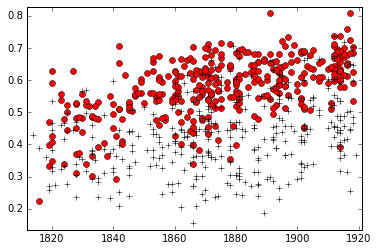

In [30]:
import matplotlib.pyplot as plt # DEFACTORING
%matplotlib inline

modeltype = 'linear'
datelimits = '
# def diachronic_tilt(allvolumes, modeltype, datelimits):
''' Takes a set of predictions produced by a model that knows nothing about date,
and divides it along a line with a diachronic tilt. We need to do this in a way
that doesn't violate crossvalidation. I.e., we shouldn't "know" anything
that the model didn't know. We tried a couple of different ways to do this, but
the simplest and actually most reliable is to divide the whole dataset along a
linear central trend line for the data!
'''

listofrows = list()
classvector = list()

# DEPRECATED
# if modeltype == 'logistic' and len(datelimits) == 2:
#     # In this case we construct a subset of data to model on.
#     tomodeldata = list()
#     tomodelclasses = list()
#     pastthreshold, futurethreshold = datelimits

for volume in allvolumes:
    date = volume[3]
    logistic = volume[8]
    realclass = volume[13]
    listofrows.append([logistic, date])
    classvector.append(realclass)

    # DEPRECATED
    # if modeltype == 'logistic' and len(datelimits) == 2:
    #     if date >= pastthreshold and date <= futurethreshold:
    #         tomodeldata.append([logistic, date])
    #         tomodelclasses.append(realclass)

y, x = [a for a in zip(*listofrows)]
plt.axis([min(x) - 2, max(x) + 2, min(y) - 0.02, max(y) + 0.02])
reviewedx = list()
reviewedy = list()
randomx = list()
randomy = list()

for idx, reviewcode in enumerate(classvector):
    if reviewcode == 1:
        reviewedx.append(x[idx])
        reviewedy.append(y[idx])
    else:
        randomx.append(x[idx])
        randomy.append(y[idx])

plt.plot(reviewedx, reviewedy, 'ro')
plt.plot(randomx, randomy, 'k+')

if modeltype == 'logistic':
    # all this is DEPRECATED
    print("Hey, you're attempting to use the logistic-tilt option")
    print("that we deactivated. Go in and uncomment the code.")

    # if len(datelimits) == 2:
    #     data = pd.DataFrame(tomodeldata)
    #     responsevariable = tomodelclasses
    # else:
    #     data = pd.DataFrame(listofrows)
    #     responsevariable = classvector

    # newmodel = LogisticRegression(C = 100000)
    # newmodel.fit(data, responsevariable)
    # coefficients = newmodel.coef_[0]

    # intercept = newmodel.intercept_[0] / (-coefficients[0])
    # slope = coefficients[1] / (-coefficients[0])

    # p = np.poly1d([slope, intercept])

elif modeltype == 'linear':
    # what we actually do

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope = z[0]
    intercept = z[1]

plt.plot(x,p(x),"b-")
plt.show(block = False)

x = np.array(x, dtype='float64')
y = np.array(y, dtype='float64')
classvector = np.array(classvector)
dividingline = intercept + (x * slope)
predicted_as_reviewed = (y > dividingline)
really_reviewed = (classvector == 1)

accuracy = sum(predicted_as_reviewed == really_reviewed) / len(classvector)

# return accuracy # DEFACTORING

tiltaccuracy = accuracy # DEFACTORING

In [ ]:
# tiltaccuracy = diachronic_tilt(allvolumes, 'linear', []) # DEFACTORING

print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', str(rawaccuracy))

print("Divided with a line fit to the data trend, it's ", str(tiltaccuracy))

## Conclusions

This notebook contains all of the code necessary to run through a full execution of the computational analysis.


Open questions for Ted:
- why does he normalize the word frequences (using `normalizearray()`) before modeling?
- Why does he normalize the coefficients (by divided by standard deviation)?

Basically, we don't have a firm understanding of why he is normalizing, mainly because we don't understand the meaning or significance of these steps on the interpretibility of the data. 

### TODO: We want to infer a 'standard' set of practices when defactoring

  - We chose 1 execution path, 1 namespace
  - To do this we broke up the code into various pieces that expressed that one execution path
  - We inspected and explicitly reported the values as a form of reporting 'state' of the execution
  - We DEFACTORED (refactored for single namespace execution) the code at places- 

### 